In [1]:
import os
import re
import numpy as np
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

In [2]:
# Directory containing the .lst files
omni_dir = "/Users/patrick/Dev/perceptive_techeval/data/omni"
temp_file_path = "/Users/patrick/Dev/perceptive_techeval/data/omni/omni_temp.csv"

# Define schema according to provided header format
schema = {
    "column_0": pl.Int32,    # Year
    "column_1": pl.Int32,    # Day of year
    "column_2": pl.Int32,    # Hour
    "column_3": pl.Int32,    # Minute
    "column_4": pl.Int32,    # IMF spacecraft ID
    "column_5": pl.Int32,    # SW Plasma spacecraft ID
    "column_6": pl.Int32,    # Number of points in IMF averages
    "column_7": pl.Int32,    # Number of points in Plasma averages
    "column_8": pl.Int32,    # Percent of Interpolation
    "column_9": pl.Int32,    # Timeshift
    "column_10": pl.Int32,   # RMS, Timeshift
    "column_11": pl.Float32, # RMS Min_var
    "column_12": pl.Int32,   # Time between observations (sec)
    "column_13": pl.Float32, # Field magnitude average (nT)
    "column_14": pl.Float32, # BX (nT, GSE, GSM)
    "column_15": pl.Float32, # BY (nT, GSE)
    "column_16": pl.Float32, # BZ (nT, GSE)
    "column_17": pl.Float32, # BY (nT, GSM)
    "column_18": pl.Float32, # BZ (nT, GSM)
    "column_19": pl.Float32, # RMS SD B scalar (nT)
    "column_20": pl.Float32, # RMS SD field vector (nT)
    "column_21": pl.Float32, # Speed (km/s)
    "column_22": pl.Float32, # Vx Velocity (km/s)
    "column_23": pl.Float32, # Vy Velocity (km/s)
    "column_24": pl.Float32, # Vz Velocity (km/s)
    "column_25": pl.Float32, # Proton Density (n/cc)
    "column_26": pl.Float32, # Proton Temperature (K)
    "column_27": pl.Float32, # Flow pressure (nPa)
    "column_28": pl.Float32, # Electric field (mV/m)
    "column_29": pl.Float32, # Plasma beta
    "column_30": pl.Float32, # Alfven mach number
    "column_31": pl.Float32, # Magnetosonic Mach number
    "column_32": pl.Float32, # S/C, Xgse (Re)
    "column_33": pl.Float32, # S/C, Ygse (Re)
    "column_34": pl.Float32, # S/c, Zgse (Re)
    "column_35": pl.Float32, # BSN location, Xgse (Re)
    "column_36": pl.Float32, # BSN location, Ygse (Re)
    "column_37": pl.Float32, # BSN location, Zgse (Re)
    "column_38": pl.Int32,   # AE-index (nT)
    "column_39": pl.Int32,   # AL-index (nT)
    "column_40": pl.Int32,   # AU-index (nT)
    "column_41": pl.Int32,   # SYM/D (nT)
    "column_42": pl.Int32,   # SYM/H (nT)
    "column_43": pl.Int32,   # ASY/D (nT)
    "column_44": pl.Int32,   # ASY/H (nT)
    "column_45": pl.Float32  # PCN-index
}

# List to store individual DataFrames
dfs = []

# Loop through each .lst file in the directory
for file in os.listdir(omni_dir):
    if file.endswith(".lst"):
        file_path = os.path.join(omni_dir, file)
        
        # Process each line in the .lst file to reformat it as CSV
        with open(file_path, 'r') as infile, open(temp_file_path, 'w') as outfile:
            for line in infile:
                # Replace multiple spaces with a single comma and add newline
                line = re.sub(r'\s+', ',', line.strip())
                outfile.write(line + '\n')
        
        # Read the processed temporary CSV file with Polars
        df = pl.read_csv(
            temp_file_path,
            separator=",",
            has_header=False,
            schema=schema,
            truncate_ragged_lines=True  # Ignore extra columns in rows
        )
        
        # Rename columns for easier readability
        df = df.rename({
            "column_0": "year",
            "column_1": "day_of_year",
            "column_2": "hour",
            "column_3": "minute",
            "column_4": "IMF_spacecraft_ID",
            "column_5": "SW_plasma_spacecraft_ID",
            "column_6": "IMF_points_count",
            "column_7": "plasma_points_count",
            "column_8": "percent_interpolation",
            "column_9": "timeshift",
            "column_10": "RMS_timeshift",
            "column_11": "RMS_min_var",
            "column_12": "time_between_observations",
            "column_13": "field_magnitude_avg",
            "column_14": "BX_GSE",
            "column_15": "BY_GSE",
            "column_16": "BZ_GSE",
            "column_17": "BY_GSM",
            "column_18": "BZ_GSM",
            "column_19": "RMS_SD_B_scalar",
            "column_20": "RMS_SD_field_vector",
            "column_21": "speed",
            "column_22": "Vx_velocity",
            "column_23": "Vy_velocity",
            "column_24": "Vz_velocity",
            "column_25": "proton_density",
            "column_26": "proton_temperature",
            "column_27": "flow_pressure",
            "column_28": "electric_field",
            "column_29": "plasma_beta",
            "column_30": "alfven_mach_number",
            "column_31": "magnetosonic_mach_number",
            "column_32": "SC_Xgse",
            "column_33": "SC_Ygse",
            "column_34": "SC_Zgse",
            "column_35": "BSN_Xgse",
            "column_36": "BSN_Ygse",
            "column_37": "BSN_Zgse",
            "column_38": "AE_index",
            "column_39": "AL_index",
            "column_40": "AU_index",
            "column_41": "SYM_D",
            "column_42": "SYM_H",
            "column_43": "ASY_D",
            "column_44": "ASY_H",
            "column_45": "PCN_index"
        })
        
        # Add Unix timestamp by converting year, day of year, hour, and minute
        timestamps = [
            (datetime(df["year"][i], 1, 1) + timedelta(days=df["day_of_year"][i] - 1, hours=df["hour"][i], minutes=df["minute"][i])).timestamp()
            for i in range(len(df))
        ]
        
        # Add the timestamp column
        df = df.with_columns(pl.Series(name="timestamp", values=timestamps))
        
        # Append to the list of DataFrames
        dfs.append(df)

# Concatenate all DataFrames into a single DataFrame
omni_df = pl.concat(dfs, how="vertical")

# Sort by timestamp for easier merging later
omni_df = omni_df.sort("timestamp")

# Save the combined DataFrame to a CSV file
omni_df.write_csv("/Users/patrick/Dev/perceptive_techeval/data/omni/combined_omni_data.csv")

In [3]:
champ_dir = "/Users/patrick/Dev/perceptive_techeval/data/champ_l2/"

df_arr = []
for file in os.listdir(champ_dir):
    if file.endswith(".csv"):
        file_path = os.path.join(champ_dir, file)
        df_arr.append(pl.read_csv(file_path))

champ_df = pl.concat(df_arr)

In [4]:
imf = omni_df[["timestamp","BZ_GSM"]].filter(pl.col("BZ_GSM") < 500) # filter their sentinel values for nan out.

a = champ_df.to_pandas()
b = imf.to_pandas()

a['timestamp'] = pd.to_datetime(a['timestamp'], unit='s')
b['timestamp'] = pd.to_datetime(b['timestamp'], unit='s')

a = a.sort_values(by="timestamp")
b = b.sort_values(by="timestamp")

champ_omni_df = pl.from_pandas(pd.merge_asof(
    a,
    b,
    on="timestamp",
    direction="nearest",
    tolerance=pd.Timedelta(hours=1.0)  # Set tolerance to one hour
))

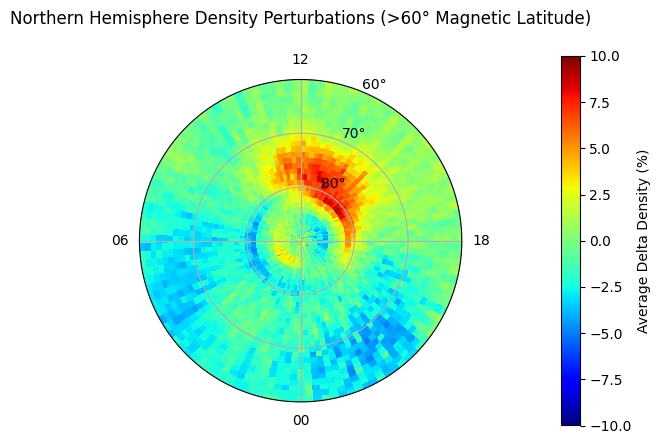

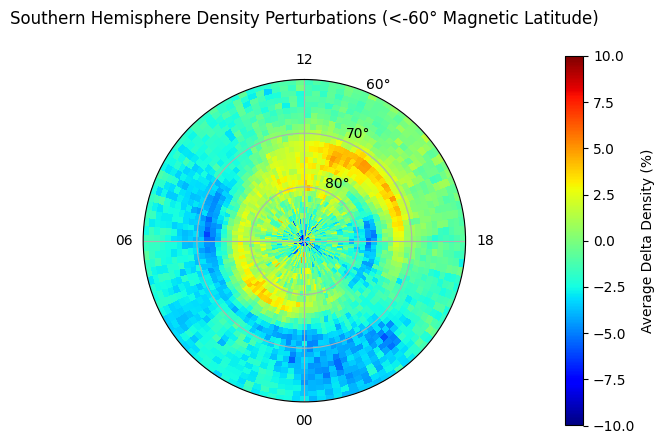

In [7]:
lat_bins = np.deg2rad(np.linspace(60, 90, 30))  # Radial bins from 60 to 90 degrees for both hemispheres
mlt_bins = np.linspace(0, 2 * np.pi, 120)  # MLT from 0 to 24 hours in radians

# Initialize histograms for North and South Hemispheres
north_hist = np.zeros((len(mlt_bins) - 1, len(lat_bins) - 1))
south_hist = np.zeros((len(mlt_bins) - 1, len(lat_bins) - 1))
north_counts = np.zeros_like(north_hist)
south_counts = np.zeros_like(south_hist)

# Calculate delta_density and filter on validity flag
df = champ_omni_df.with_columns(
            delta_density=100.0 * (pl.col("density") - pl.col("density").rolling_mean(30)) / pl.col("density").rolling_mean(30)
).filter(pl.col("validity_flag") == 0)  # Only keep rows where validity_flag is 0

df = df.filter(
    pl.fold(
        acc=True,
        function=lambda acc, col: acc & col.is_finite(),
        exprs=[pl.col(col) for col in df.columns if df.schema[col] == pl.Float64]
    )
)

# Filter for Northern and Southern Hemispheres within 60-90° range
df_north = df.filter((pl.col("geomagnetic_latitude") >= 60) & (pl.col("geomagnetic_latitude") <= 90))
df_south = df.filter((pl.col("geomagnetic_latitude") <= -60) & (pl.col("geomagnetic_latitude") >= -90))

# Convert geomagnetic latitude and MLT to radians
geom_lat_north_radians = np.deg2rad(df_north["geomagnetic_latitude"].to_numpy())
mlt_north_radians = ((24 - df_north["mlt"].to_numpy()) / 24) * 2 * np.pi  # Flip MLT data
geom_lat_south_radians = np.deg2rad(np.abs(df_south["geomagnetic_latitude"].to_numpy()))
mlt_south_radians = ((24 - df_south["mlt"].to_numpy()) / 24) * 2 * np.pi  # Flip MLT data

# Calculate 2D histograms with delta_density as weights
hist_north, _, _ = np.histogram2d(mlt_north_radians, geom_lat_north_radians, bins=(mlt_bins, lat_bins),                                       weights=df_north["delta_density"].to_numpy())
counts_north, _, _ = np.histogram2d(mlt_north_radians, geom_lat_north_radians, bins=(mlt_bins, lat_bins))

hist_south, _, _ = np.histogram2d(mlt_south_radians, geom_lat_south_radians, bins=(mlt_bins, lat_bins),                                            weights=df_south["delta_density"].to_numpy())
counts_south, _, _ = np.histogram2d(mlt_south_radians, geom_lat_south_radians, bins=(mlt_bins, lat_bins))

north_hist += hist_north
south_hist += hist_south
north_counts += counts_north
south_counts += counts_south

# Compute average delta_density for each bin by dividing by counts and converting to percentage
avg_north_density = np.divide(north_hist, north_counts, out=np.zeros_like(north_hist), where=north_counts > 0)
avg_south_density = np.divide(south_hist, south_counts, out=np.zeros_like(south_hist), where=south_counts > 0)

# Define mesh grid for polar plot
A_north, R_north = np.meshgrid(mlt_bins, lat_bins)
A_south, R_south = np.meshgrid(mlt_bins, lat_bins)

# Plot for Northern Hemisphere
fig, ax = plt.subplots(subplot_kw=dict(projection="polar"))
ax.set_ylim(np.deg2rad(90), np.deg2rad(60))  # Invert the radial axis to have 90° at the center and 60° at the outer edge

pc = ax.pcolormesh(A_north, R_north, avg_north_density.T, cmap="jet", vmin=-10, vmax=10)
fig.colorbar(pc, ax=ax, label="Average Delta Density (%)", pad=.2)
ax.set_title("Northern Hemisphere Density Perturbations (>60° Magnetic Latitude)\n")

# Set MLT ticks in hours for Northern Hemisphere
mlt_ticks = np.linspace(0, 2 * np.pi, 4, endpoint=False)  # Ticks at every 6 hours
mlt_labels = ["12", "18", "00", "06"]
ax.set_xticks(mlt_ticks)
ax.set_xticklabels(mlt_labels)
ax.set_theta_zero_location("N")  # Set 12 (noon) at the top
ax.set_theta_direction(-1)  # Clockwise direction

# Set custom radial ticks in degrees for Northern Hemisphere
radial_ticks_north = [80, 70, 60]
ax.set_yticks(np.deg2rad(radial_ticks_north))
ax.set_yticklabels([f"{tick}°" for tick in radial_ticks_north])

# Plot for Southern Hemisphere
fig, ax = plt.subplots(subplot_kw=dict(projection="polar"))
ax.set_ylim(np.deg2rad(90), np.deg2rad(60))  # Invert the radial axis to have 90° at the center and 60° at the outer edge

pc = ax.pcolormesh(A_south, R_south, avg_south_density.T, cmap="jet", vmin=-10, vmax=10)
fig.colorbar(pc, ax=ax, label="Average Delta Density (%)", pad=.2)
ax.set_title("Southern Hemisphere Density Perturbations (<-60° Magnetic Latitude)\n")

# Set MLT ticks in hours for Southern Hemisphere
ax.set_xticks(mlt_ticks)
ax.set_xticklabels(mlt_labels)
ax.set_theta_zero_location("N")  # Set 12 (noon) at the top
ax.set_theta_direction(-1)  # Clockwise direction

# Set custom radial ticks in degrees for Southern Hemisphere
radial_ticks_south = [80, 70, 60]
ax.set_yticks(np.deg2rad(radial_ticks_south))
ax.set_yticklabels([f"{tick}°" for tick in radial_ticks_south])

plt.show()

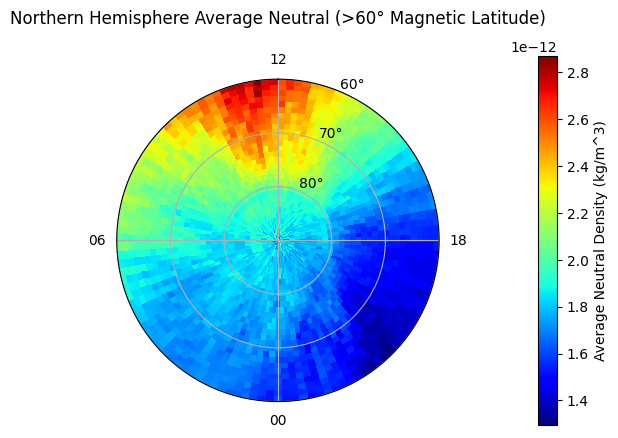

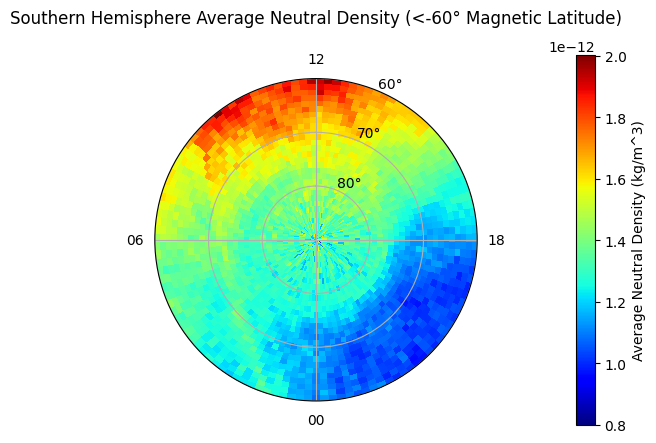

In [8]:
lat_bins = np.deg2rad(np.linspace(60, 90, 30))  # Radial bins from 60 to 90 degrees for both hemispheres
mlt_bins = np.linspace(0, 2 * np.pi, 120)  # MLT from 0 to 24 hours in radians

# Initialize histograms for North and South Hemispheres
north_hist = np.zeros((len(mlt_bins) - 1, len(lat_bins) - 1))
south_hist = np.zeros((len(mlt_bins) - 1, len(lat_bins) - 1))
north_counts = np.zeros_like(north_hist)
south_counts = np.zeros_like(south_hist)

# Calculate delta_density and filter on validity flag
df = champ_omni_df.with_columns(
            delta_density=100.0 * (pl.col("density") - pl.col("density").rolling_mean(30)) / pl.col("density").rolling_mean(30)
).filter(pl.col("validity_flag") == 0)  # Only keep rows where validity_flag is 0

df = df.filter(
    pl.fold(
        acc=True,
        function=lambda acc, col: acc & col.is_finite(),
        exprs=[pl.col(col) for col in df.columns if df.schema[col] == pl.Float64]
    )
)

# Filter for Northern and Southern Hemispheres within 60-90° range
df_north = df.filter((pl.col("geomagnetic_latitude") >= 60) & (pl.col("geomagnetic_latitude") <= 90))
df_south = df.filter((pl.col("geomagnetic_latitude") <= -60) & (pl.col("geomagnetic_latitude") >= -90))

# Convert geomagnetic latitude and MLT to radians
geom_lat_north_radians = np.deg2rad(df_north["geomagnetic_latitude"].to_numpy())
mlt_north_radians = ((24 - df_north["mlt"].to_numpy()) / 24) * 2 * np.pi  # Flip MLT data
geom_lat_south_radians = np.deg2rad(np.abs(df_south["geomagnetic_latitude"].to_numpy()))
mlt_south_radians = ((24 - df_south["mlt"].to_numpy()) / 24) * 2 * np.pi  # Flip MLT data

# Calculate 2D histograms with delta_density as weights
hist_north, _, _ = np.histogram2d(mlt_north_radians, geom_lat_north_radians, bins=(mlt_bins, lat_bins),                                       weights=df_north["density"].to_numpy())
counts_north, _, _ = np.histogram2d(mlt_north_radians, geom_lat_north_radians, bins=(mlt_bins, lat_bins))

hist_south, _, _ = np.histogram2d(mlt_south_radians, geom_lat_south_radians, bins=(mlt_bins, lat_bins),                                            weights=df_south["density"].to_numpy())
counts_south, _, _ = np.histogram2d(mlt_south_radians, geom_lat_south_radians, bins=(mlt_bins, lat_bins))

north_hist += hist_north
south_hist += hist_south
north_counts += counts_north
south_counts += counts_south

# Compute average delta_density for each bin by dividing by counts and converting to percentage
avg_north_density = np.divide(north_hist, north_counts, out=np.zeros_like(north_hist), where=north_counts > 0)
avg_south_density = np.divide(south_hist, south_counts, out=np.zeros_like(south_hist), where=south_counts > 0)

# Define mesh grid for polar plot
A_north, R_north = np.meshgrid(mlt_bins, lat_bins)
A_south, R_south = np.meshgrid(mlt_bins, lat_bins)

# Plot for Northern Hemisphere
fig, ax = plt.subplots(subplot_kw=dict(projection="polar"))
ax.set_ylim(np.deg2rad(90), np.deg2rad(60))  # Invert the radial axis to have 90° at the center and 60° at the outer edge

pc = ax.pcolormesh(A_north, R_north, avg_north_density.T, cmap="jet")
fig.colorbar(pc, ax=ax, label="Average Neutral Density (kg/m^3)", pad=.2)
ax.set_title("Northern Hemisphere Average Neutral (>60° Magnetic Latitude)\n")

# Set MLT ticks in hours for Northern Hemisphere
mlt_ticks = np.linspace(0, 2 * np.pi, 4, endpoint=False)  # Ticks at every 6 hours
mlt_labels = ["12", "18", "00", "06"]
ax.set_xticks(mlt_ticks)
ax.set_xticklabels(mlt_labels)
ax.set_theta_zero_location("N")  # Set 12 (noon) at the top
ax.set_theta_direction(-1)  # Clockwise direction

# Set custom radial ticks in degrees for Northern Hemisphere
radial_ticks_north = [80, 70, 60]
ax.set_yticks(np.deg2rad(radial_ticks_north))
ax.set_yticklabels([f"{tick}°" for tick in radial_ticks_north])

# Plot for Southern Hemisphere
fig, ax = plt.subplots(subplot_kw=dict(projection="polar"))
ax.set_ylim(np.deg2rad(90), np.deg2rad(60))  # Invert the radial axis to have 90° at the center and 60° at the outer edge

pc = ax.pcolormesh(A_south, R_south, avg_south_density.T, cmap="jet")
fig.colorbar(pc, ax=ax, label="Average Neutral Density (kg/m^3)", pad=.2)
ax.set_title("Southern Hemisphere Average Neutral Density (<-60° Magnetic Latitude)\n")

# Set MLT ticks in hours for Southern Hemisphere
ax.set_xticks(mlt_ticks)
ax.set_xticklabels(mlt_labels)
ax.set_theta_zero_location("N")  # Set 12 (noon) at the top
ax.set_theta_direction(-1)  # Clockwise direction

# Set custom radial ticks in degrees for Southern Hemisphere
radial_ticks_south = [80, 70, 60]
ax.set_yticks(np.deg2rad(radial_ticks_south))
ax.set_yticklabels([f"{tick}°" for tick in radial_ticks_south])

plt.show()